# Importing Libraries and Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.geometry import MultiPoint
from shapely.ops import linemerge

import os
import shutil
from pathlib import Path
from PIL import Image

import torch
from torchvision import models
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from torchvision.models import VGG16_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from collections import Counter

In [3]:
# Load data from the London_UK folder.
data_path = Path('London_UK')

panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
streets = gpd.read_file(data_path / 'network/edges/edges.geojson')

# Splitting road network

In this step, the road network is split in smaller segments to later be classified.

In [4]:
# Define the function that splits the larger initial network LineStrings in segments no bigger than 50 metres.
def split_line(line, max_segment_length=50):
    # Calculate the number of segments
    num_segments = int(line.length // max_segment_length) + 1
    segment_length = line.length / num_segments
    
    # Create a list to store the segments
    segments = []
    
    # Generate points along the line at each segment length
    for i in range(num_segments):
        start_point = line.interpolate(i * segment_length)
        end_point = line.interpolate(min((i + 1) * segment_length, line.length))
        segment = LineString([start_point, end_point])
        segments.append(segment)
    
    return segments

# Re-project to a suitable CRS if necessary
if streets.crs.is_geographic:
    streets = streets.to_crs(epsg=27700)  # 27700 is the most suited for Great Britain

# Calculate lengths
streets['length'] = streets.length

# Split lines longer than 100 meters
split_segments = []
for _, row in streets.iterrows():
    if row['length'] > 100:
        split_segments.extend(split_line(row['geometry'], max_segment_length=50))
    else:
        split_segments.append(row['geometry'])

# Create a new GeoDataFrame with the split segments
split_streets_gdf_max = gpd.GeoDataFrame(geometry=split_segments, crs=streets.crs)

# Calculate the new lengths
split_streets_gdf_max_L = split_streets_gdf_max.length

split_streets_gdf_max['length'] = split_streets_gdf_max_L


In [5]:
# Function to merge all new LineStings smaller than 10 metres.
def merge_short_lines(streets_gdf, min_total_length=50, max_individual_length=10):
    merged_segments = []
    current_merge = []

    for _, row in streets_gdf.iterrows():
        line = row['geometry']
        line_length = line.length

        if line_length < max_individual_length:
            current_merge.append(line)
            total_length = sum([seg.length for seg in current_merge])

            if total_length >= min_total_length:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
        else:
            if current_merge:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
            merged_segments.append(line)

    # If there are any remaining lines in the current merge, add them
    if current_merge:
        merged_line = linemerge(current_merge)
        merged_segments.append(merged_line)

    return gpd.GeoDataFrame(geometry=merged_segments, crs=streets_gdf.crs)

# Merge short lines
merged_streets_gdf = merge_short_lines(split_streets_gdf_max)

# Optionally, calculate the new lengths
merged_streets_gdf['length'] = merged_streets_gdf.length


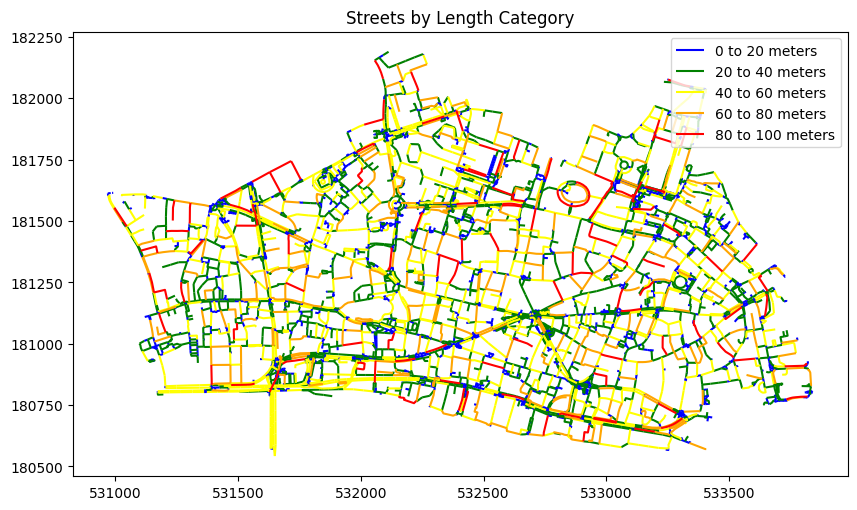

In [6]:
# Define a function to categorize lengths and assign colors
def categorize_and_plot(gdf):
    # Define the bins and corresponding colors
    bins = [0, 20, 40, 60, 80, 100]
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    
    # Create a new column 'category' based on the length
    gdf['category'] = np.digitize(gdf['length'], bins, right=True)
    
    # Plot each category with a different color
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, color in enumerate(colors, start=1):
        category_gdf = gdf[gdf['category'] == i]
        if not category_gdf.empty:
            category_gdf.plot(ax=ax, color=color, label=f'{bins[i-1]} to {bins[i]} meters')
    
    plt.title('Streets by Length Category')
    plt.legend()
    plt.show()

# Call the function to categorize and plot
categorize_and_plot(merged_streets_gdf)

# Associating images with street segments

In [ ]:
# Creates a panoids GeoDataFrame
panoids_gdf = gpd.GeoDataFrame(
    panoids,
    geometry=[Point(xy) for xy in zip(panoids['lng'], panoids['lat'])],
    crs='EPSG:4326'  # Assuming WGS 84
)

# Ensure both GeoDataFrames are in the same CRS
if merged_streets_gdf.crs != panoids_gdf.crs:
    panoids_gdf = panoids_gdf.to_crs(merged_streets_gdf.crs)

# Ensure the GeoDataFrame is in a projected CRS for accurate buffer calculations
if merged_streets_gdf.crs.is_geographic:
    merged_streets_gdf = merged_streets_gdf.to_crs(epsg=27700)  # Example: British National Grid
    
# Create a buffer of 20 meters around each LineString
merged_streets_gdf['buffer'] = merged_streets_gdf.geometry.buffer(20)

# Perform a spatial join to find which panoids fall within the buffer
panoids_in_buffer = gpd.sjoin(panoids_gdf, merged_streets_gdf.set_geometry('buffer'), how='inner', predicate='within')

# Group by the index of the LineString and aggregate panoids
linestring_panoids = panoids_in_buffer.groupby('index_right')['panoid'].apply(list).reset_index()

      index_right                                             panoid
0               5                           [xdou9yN5jG9HVTpAHFIKNA]
1               6   [Ym72WsFbvhBpr0D19DxasA, xdou9yN5jG9HVTpAHFIKNA]
2               8                           [xdou9yN5jG9HVTpAHFIKNA]
3               9  [xHxCUvX5chMOydy9WdcHRA, g6G6Rza4wCHAFyyGH1lF0...
4              10  [DW0rSBghzK_zKlEqzFS07w, hO7nswlVtu2Qa9I2y0oLN...
...           ...                                                ...
4290         5025  [VgB1-T_mMoImrsdbc9pAZA, ruQvGAcacOZK2SC3zwoKT...
4291         5026  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...
4292         5027  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...
4293         5028  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...
4294         5030  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...

[4295 rows x 2 columns]


C:\Users\fmaca\AppData\Local\Temp\ipykernel_7912\788597189.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


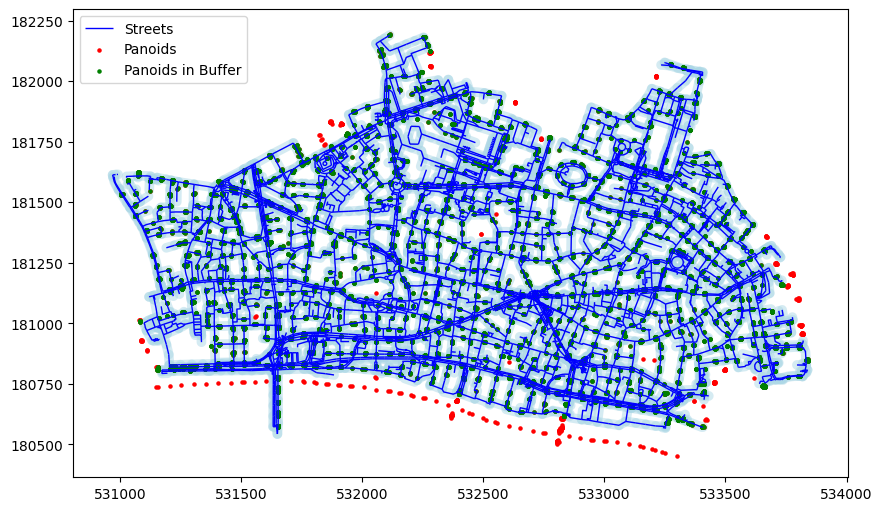

In [78]:
# Visualize the data
fig, ax = plt.subplots(figsize=(10, 10))
merged_streets_gdf.plot(ax=ax, color='blue', linewidth=1, label='Streets')
merged_streets_gdf['buffer'].plot(ax=ax, color='lightblue', alpha=0.5, label='Buffer (20m)')
panoids_gdf.plot(ax=ax, color='red', markersize=5, label='Panoids')
panoids_in_buffer.plot(ax=ax, color='green', markersize=5, label='Panoids in Buffer')
plt.legend()
plt.show()

# Model

## Categorizing manually classified data

In [79]:
# Base directory where the subdirectories are located
base_dir = Path('London_UK\imagedb')

# Define the subdirectories and their corresponding image lists with the manually classified panoids
categories = {
    'residential_road': [
        "410_s_a", "410_f", "410_s_b", "410_b", "417_s_a", "417_s_b", "568_s_a", "568_f", "568_s_b", "619_f",
        "619_s_b", "619_b", "754_f", "754_s_b", "754_b", "806_s_a", "806_f", "806_s_b", "806_b", "981_f",
        "981_b", "1116_s_a", "1116_f", "1116_s_b", "1116_b", "1430_s_a", "1430_f", "1430_s_b", "1430_b",
        "1465_s_b", "1750_s_a", "1750_f", "1750_s_b", "1750_b", "2166_s_a", "2497_f", "2497_b", "3235_s_a",
        "3235_f", "3235_s_b", "3235_b", "3264_f", "3264_b", "3757_s_a", "3757_f", "3757_s_b", "3757_b",
        "3797_s_a", "3797_f", "3797_s_b", "3797_b", "3852_f", "3852_s_b", "3852_b", "4142_s_a", "4142_f",
        "4142_s_b", "4142_b", "4187_s_a", "4187_f", "4187_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4810_s_a", "4810_f", "4880_s_a", "4880_f", "4880_s_b", "4880_b", "4985_s_a", "5074_s_a", "5074_f",
        "5074_s_b", "5079_f", "5079_b", "5136_s_a", "5136_f", "5136_s_b", "5136_b", "5160_f", "5160_b",
        "5338_s_a", "5338_f", "5338_s_b", "5338_b", "5379_s_a", "5379_s_b", "5869_f", "5869_s_b", "5869_b",
        "6417_s_a", "6417_f", "6417_s_b", "6417_b", "7028_f", "7028_b", "7039_f", "7039_b", "7486_f",
        "7486_b", "7795_s_a", "7795_f", "7795_b", "7822_s_a", "7822_f", "7822_s_b", "7822_b", "8285_f",
        "8324_s_a", "8324_s_b", "8346_s_a", "8346_f", "8346_s_b", "8346_b", "8435_s_a", "8435_f", "8435_s_b",
        "8435_b", "8594_s_a", "8594_f", "8594_s_b", "8594_b"
    ],
    'main_road': [
        "148_s_a", "148_f", "148_s_b", "148_b", "417_f", "417_b", "466_s_a", "466_f", "466_s_b", "466_b",
        "504_s_a", "504_f", "504_s_b", "504_b", "568_b", "582_s_a", "582_s_b", "582_b", "590_f", "590_s_b",
        "590_b", "811_s_a", "811_f", "811_b", "940_f", "940_s_b", "940_b", "946_s_a", "946_f", "946_s_b",
        "946_b", "1302_s_a", "1302_b", "1334_f", "1334_b", "1465_f", "1465_b", "1568_s_a", "2145_f", "2145_s_b",
        "2145_b", "2166_f", "2166_b", "2206_s_a", "2206_f", "2206_s_b", "2206_b", "2281_s_a", "2281_f", "2281_s_b",
        "2281_b", "2410_s_a", "2410_f", "2410_s_b", "2980_f", "2980_b", "2991_s_a", "2991_f", "2991_s_b", "2999_s_a",
        "2999_f", "2999_s_b", "2999_b", "3310_s_a", "3310_f", "3310_s_b", "3310_b", "3456_f", "3456_s_b", "3456_b",
        "3640_s_a", "3640_f", "3640_b", "3759_s_a", "3759_f", "3759_s_b", "3759_b", "3836_s_a", "3836_f", "3836_s_b",
        "3836_b", "4003_f", "4003_s_b", "4003_b", "4010_f", "4010_b", "4090_s_a", "4090_f", "4090_s_b", "4090_b",
        "4356_s_a", "4356_f", "4356_s_b", "4356_b", "4527_s_a", "4527_f", "4527_s_b", "4527_b", "4551_s_a", "4551_f",
        "4551_b", "4679_s_a", "4679_f", "4679_s_b", "4679_b", "4699_s_a", "4699_f", "4699_s_b", "4699_b", "4724_s_a",
        "4724_f", "4724_s_b", "4724_b", "4768_f", "4768_s_b", "4768_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4985_s_a", "4985_f", "4985_s_b", "4985_b", "5190_s_a", "5190_f", "5190_s_b", "5190_b", "5379_s_a", "5379_f",
        "5379_b", "5411_s_a", "5411_f", "5411_b", "6125_f", "6125_b", "6558_f", "6558_b", "6793_s_a", "6793_f",
        "6793_s_b", "6793_b", "6954_s_a", "6954_f", "6954_s_b", "6985_s_a", "6985_f", "6985_s_b", "6985_b", "7062_s_a",
        "7062_f", "7062_s_b", "7062_b", "7074_f", "7074_s_b", "7074_b", "7155_s_a", "7155_f", "7155_s_b", "7155_b",
        "7499_b", "7715_s_a", "7715_f", "7715_s_b", "7715_b", "7973_f", "7973_b", "8009_s_a", "8009_f", "8009_s_b",
        "8009_b", "8285_s_b", "8285_b", "8324_s_a", "8324_f", "8324_s_b", "8324_b", "8391_s_a", "8391_f", "8391_s_b",
        "8971_s_a", "8971_f", "8971_s_b", "8971_b"
    ],
    'pedestrian_road': [
        "582_f", "590_s_a", "619_s_a", "619_s_b", "754_s_a", "754_b", "806_s_a", "806_f", "806_s_b", "806_b",
        "811_s_b", "940_s_a", "981_s_a", "981_s_b", "1263_s_a", "1263_f", "1263_s_b", "1263_b", "1302_f", "1302_s_b",
        "1334_s_a", "1334_s_b", "1465_s_a", "1465_s_b", "1485_s_a", "1485_f", "1485_s_b", "1485_b", "1568_f", "1568_s_b",
        "1568_b", "2145_s_a", "2166_s_b", "2410_b", "2497_s_b", "2980_s_a", "2980_s_b", "2991_b", "3264_s_a", "3264_s_b",
        "3456_s_a", "3640_s_b", "3852_s_a", "4003_s_a", "4010_s_a", "4010_s_b", "4187_s_a", "4187_s_b", "4551_s_b",
        "4768_s_a", "4810_s_a", "4810_b", "5074_b", "5079_s_a", "5079_s_b", "5160_s_a", "5160_s_b", "5338_s_a", "5338_s_b",
        "5411_s_b", "5869_s_a", "6125_s_a", "6125_s_b", "6558_s_a", "6558_s_b", "6954_b", "6955_s_a", "6955_f", "6955_s_b",
        "6955_b", "7028_s_a", "7028_s_b", "7039_s_a", "7039_s_b", "7074_s_a", "7166_s_a", "7166_f", "7166_s_b", "7166_b",
        "7486_s_a", "7486_s_b", "7499_s_a", "7499_f", "7499_s_b", "7795_s_b", "7973_s_a", "7973_s_b", "8285_s_a", "8285_f",
        "8391_b", "8709_s_a", "8709_f", "8709_s_b", "8709_b", "8784_s_a", "8784_f", "8784_s_b", "8784_b"
    ]
}

# Destination directory to save images into subfolders
destination_dir = Path('classified_data')

# Create DataFrames and copy images to respective subfolders
for category, filenames in categories.items():
    # Construct the full path for each image
    image_paths = [os.path.join(base_dir, f"image_{filename}.png") for filename in filenames]
    
    # Create the subfolder if it doesn't exist
    category_path = os.path.join(destination_dir, category)
    os.makedirs(category_path, exist_ok=True)
    
    # Copy each image to the corresponding subfolder
    for image_path, filename in zip(image_paths, filenames):
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(category_path, f"image_{filename}.png"))
        else:
            print(f"Image not found: {image_path}")

    print(f"Images copied to {category_path}")

print("✅ All images have been sorted into subfolders.")


Images copied to classified_data\residential_road
Images copied to classified_data\main_road
Images copied to classified_data\pedestrian_road
✅ All images have been sorted into subfolders.


## Model trainning

In [80]:
# We first calculate the mean and standard deviation to create 
# In order to classify the streets based on the images, first a mean and standard deviation tensor is created to store the means and standard deviations of each class of street use.
dataset = ImageFolder(root=destination_dir, transform=ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = torch.tensor([0.0, 0.0, 0.0])
std = torch.tensor([0.0, 0.0, 0.0])
for images, _ in loader:
    # Compute mean and std per batch
    batch_mean = torch.mean(images, dim=[0, 2, 3])
    batch_std = torch.std(images, dim=[0, 2, 3])
    mean += batch_mean
    std += batch_std
mean /= len(loader)
std /= len(loader)

print(f"Dataset Mean: {mean}, Dataset Std: {std}")


Dataset Mean: tensor([0.4205, 0.4171, 0.4113]), Dataset Std: tensor([0.2165, 0.2145, 0.2206])


In [81]:
# step 1: transform the dataset (Resize, ToTensor and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reduce image size, 224x224 is a common format for benchmarking CNNs
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# The dataset is loaded
train_dataset = ImageFolder(root=destination_dir, transform=transform)

## split the data into training set and validation set
num_train = int(0.8 * len(train_dataset))
num_test = len(train_dataset) - num_train
train_data, val_data = random_split(train_dataset, [num_train, num_test])

#Data loaders are created
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)


In [82]:
# step 2: define the model
# The model used is based on the ResNet-34 architecture, chosen because of its robustness for image classification.
# We're going to apply transfer learning by using the pretrained model on ImageNet.
# The final layer is changed to better suit our needs for this specific classification problem.
# In this case a classification problem with 3 labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes)) # Replace the final layer with a new one adjusted for the number of classes in our dataset
model.to(device)
summary(model, input_size=(3, 224, 224))  
## the last layer of original resnet output is 1000x1 vector, but now we only have 3 features
## for the final vector, each element represents the score for each classification"


C:\Users\fmaca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fmaca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [83]:
# step 3: train the model
# for basic CNN evaluation, we need to focus on Training Loss, Validation Loss, Validation Accuracy, Validation Precision, Validation Recall, Validation F1 Score

criterion = nn.CrossEntropyLoss() # this is the loss function, we can change it to other loss functions but this one is good

def train(model, train_loader, path='best_model.pth', lr=0.005):
    # Define loss function, optimizer and training epochs
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Initialize the metrics
    metrics = {'training losses': [],
               'validation losses': [],
               'validation accuracies': [],
               'validation precisions': [],
               'validation recalls': [],
               'validation f1 scores': []}
    # We keep track of the best validation accuracy and save the best model
    best_val_accuracy = 0.0
    
    # training loop
    for epoch in range(10):  
        model.train()
        training_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        # Store average training loss for the epoch
        metrics['training losses'].append(training_loss / len(train_loader))

        # Validation loop
        model.eval()
        validation_loss = 0.0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())
        
        # Calculate validation loss
        metrics['validation losses'].append(validation_loss / len(val_loader))

        # Calculate metrics
        accuracy = 100 * accuracy_score(true_labels, predicted_labels)
        precision = 100 * precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
        recall = 100 * recall_score(true_labels, predicted_labels, average='macro')
        f1 = 100 * f1_score(true_labels, predicted_labels, average='weighted')

        # Store metrics
        metrics['validation accuracies'].append(accuracy)
        metrics['validation precisions'].append(precision)
        metrics['validation recalls'].append(recall)
        metrics['validation f1 scores'].append(f1)

        # save best model based on validation accuracy
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), path)
            print(f"Epoch {epoch+1}: Improved validation accuracy to {best_val_accuracy:.2f}%. Model saved.")

        print(f'Epoch {epoch+1}/{10}', f'Train Loss: {metrics["training losses"][-1]:.4f}, '
            f'Validation Loss: {metrics["validation losses"][-1]:.4f}, '
            f'Accuracy: {metrics["validation accuracies"][-1]:.2f}%')

    return metrics


In [84]:
metrics = train(model, train_loader)
# Load the best model after training is complete
model.load_state_dict(torch.load('best_model.pth'))
print("Loaded best model from:", 'best_model.pth')
print(metrics)


Epoch 1: Improved validation accuracy to 30.56%. Model saved.
Epoch 1/10 Train Loss: 2.3757, Validation Loss: 1382461696.0000, Accuracy: 30.56%
Epoch 2: Improved validation accuracy to 44.44%. Model saved.
Epoch 2/10 Train Loss: 1.2547, Validation Loss: 2196522.4375, Accuracy: 44.44%
Epoch 3/10 Train Loss: 1.1758, Validation Loss: 21040.5139, Accuracy: 44.44%
Epoch 4/10 Train Loss: 1.3323, Validation Loss: 427.7554, Accuracy: 44.44%
Epoch 5/10 Train Loss: 1.1466, Validation Loss: 46.0993, Accuracy: 44.44%
Epoch 6/10 Train Loss: 1.2524, Validation Loss: 163.2773, Accuracy: 43.83%
Epoch 7/10 Train Loss: 1.1120, Validation Loss: 17.9483, Accuracy: 34.26%
Epoch 8/10 Train Loss: 1.1434, Validation Loss: 4.6778, Accuracy: 44.44%
Epoch 9/10 Train Loss: 1.0110, Validation Loss: 3.4786, Accuracy: 44.44%
Epoch 10/10 Train Loss: 1.0116, Validation Loss: 3.2761, Accuracy: 44.44%
Loaded best model from: best_model.pth
{'training losses': [2.3757193088531494, 1.254728227853775, 1.1757689515749614, 1

C:\Users\fmaca\AppData\Local\Temp\ipykernel_7912\1021844405.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


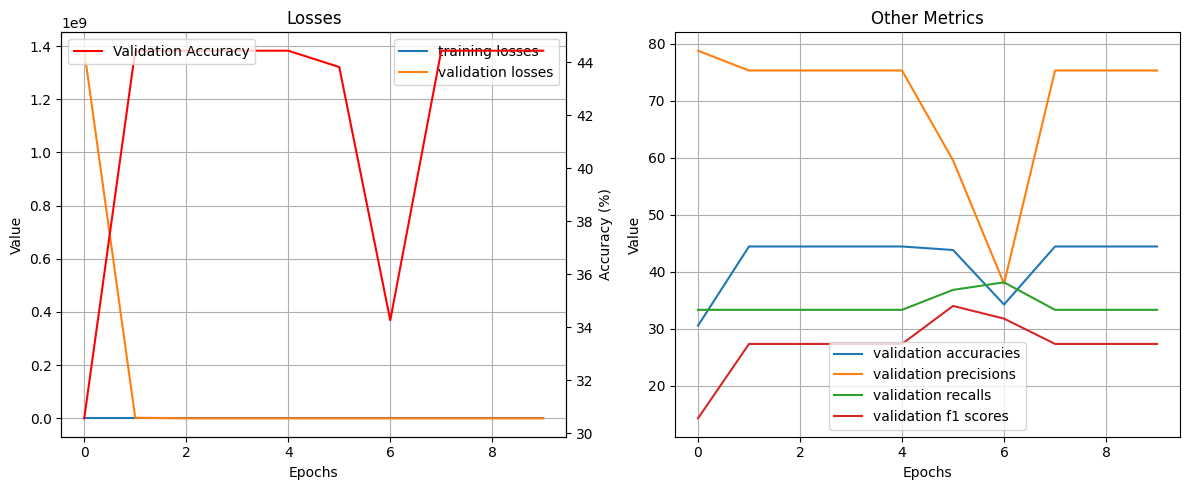

In [85]:
# step 4: plot the results
def visualize(metrics):
    cpu_metrics = {'training losses': [],
                   'validation losses': [],
                   'validation accuracies': [],
                   'validation precisions': [],
                   'validation recalls': [],
                   'validation f1 scores': []}

    for key, values in metrics.items():
        cpu_metrics[key] = [val.cpu().item() if hasattr(val, 'cpu') else val for val in values]

    losses = ['training losses', 'validation losses']
    other_metrics = ['validation accuracies', 'validation precisions', 'validation recalls', 'validation f1 scores']

    # Create figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot for losses
    axs[0].set_title('Losses')
    for metric in losses:
        axs[0].plot(cpu_metrics[metric], label=metric)
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True)

    # Instantiate a second y-axis sharing the same x-axis
    ax2 = axs[0].twinx()
    ax2.plot(cpu_metrics['validation accuracies'], 'r-', label='Validation Accuracy')
    ax2.set_ylabel('Accuracy (%)')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper left')

    # Plot for other metrics
    axs[1].set_title('Other Metrics')
    for metric in other_metrics:
        axs[1].plot(cpu_metrics[metric], label=metric)
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

visualize(metrics)


## Freezing layers


In [ ]:
# Load the ResNet-34 model
resnet34 = models.resnet34(pretrained=True) # This ensures we load the pretrained weights

# We need to know the number of features in the last layer of the pretrained model to adapt our classifier.
# These are equal to the number of inputs of the "fully connected" (fc) head of the ResNet-34.
num_ftrs = resnet34.fc.in_features

# Modify the fully connected layer to match the number of classes for the land use identification case study
num_classes = 3
resnet34.fc = nn.Linear(num_ftrs, num_classes)
num_outputs = resnet34.fc.out_features
print(f"The modified ResNet-18 predicts {num_outputs} classes")

# Freeze all the layers
for param in resnet34.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in resnet34.fc.parameters():
    param.requires_grad = True

# Check that only the last two layers are not frozen (hidden and output layer of the classifier)
for param in resnet34.parameters():
    print(param.requires_grad)


/Users/tangshiya/anaconda3/envs/DSAIE/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tangshiya/anaconda3/envs/DSAIE/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The modified ResNet-18 predicts 3 classes
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
metrics = train(resnet34, train_loader, path='/Users/tangshiya/DSAIE/1.24-2/best_model_2.pth')
# Load the best model after training is complete
resnet34.load_state_dict(torch.load('/Users/tangshiya/DSAIE/1.24-2/best_model_2.pth'))
print("Loaded best model from:", '/Users/tangshiya/DSAIE/1.24-2/best_model_2.pth')
print(metrics)


Epoch 1: Improved validation accuracy to 36.73%. Model saved.
Epoch 1/10 Train Loss: 1.5396, Validation Loss: 3.3146, Accuracy: 36.73%
Epoch 2: Improved validation accuracy to 52.16%. Model saved.
Epoch 2/10 Train Loss: 1.1425, Validation Loss: 3.8445, Accuracy: 52.16%
Epoch 3: Improved validation accuracy to 60.49%. Model saved.
Epoch 3/10 Train Loss: 0.9077, Validation Loss: 2.6319, Accuracy: 60.49%
Epoch 4: Improved validation accuracy to 61.11%. Model saved.
Epoch 4/10 Train Loss: 0.8709, Validation Loss: 2.3415, Accuracy: 61.11%
Epoch 5: Improved validation accuracy to 61.42%. Model saved.
Epoch 5/10 Train Loss: 0.7782, Validation Loss: 2.4690, Accuracy: 61.42%
Epoch 6: Improved validation accuracy to 67.90%. Model saved.
Epoch 6/10 Train Loss: 0.8793, Validation Loss: 2.2523, Accuracy: 67.90%
Epoch 7: Improved validation accuracy to 72.53%. Model saved.
Epoch 7/10 Train Loss: 0.7511, Validation Loss: 1.8616, Accuracy: 72.53%
Epoch 8/10 Train Loss: 0.9231, Validation Loss: 2.1413,

/var/folders/bm/sxsv4gs910ldhzb8ckc3py9r0000gn/T/ipykernel_45012/1371325765.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load('/Users/t